1. 라이브러리 로딩 및 한글 폰트 설정

In [ ]:
import pandas as pd                 # DB 분석 위한 핵심 라이브러리 -> DataFrame, Series 등 DB 구조 제공
import numpy as np                  # 수치 연산 위한 핵심 라이브러리 -> 수치 계산, 배열 연산
import matplotlib.pyplot as plt     # 시각화 위한 핵심 라이브러리 -> 그래프, 차트 그리기
import seaborn as sns               # 시각화 위한 핵심 라이브러리 -> matplolib 기반 고급 통계 시각화 라이브러리
from scipy import stats             # 통계 연산 위한 핵심 라이브러리 -> 통계 분석, 확률 분포 관련 함수들 제공
import warnings                     # 경고 메세지 제어
warnings.filterwarnings('ignore')   # 경고 메세지 무시

# 한글 폰트 설정
import matplotlib.font_manager as fm
font_list = [font.name for font in fm.fontManager.ttflist if 'Gothic' in font.name or 'Malgun' in font.name]
if font_list:
    plt.rcParams['font.family'] = font_list[0]
else:
    # 대안 폰트들
    try:
        plt.rcParams['font.family'] = 'Malgun Gothic'
    except:
        try:
            plt.rcParams['font.family'] = 'Microsoft YaHei'
        except:
            plt.rcParams['font.family'] = 'DejaVu Sans'

plt.rcParams['axes.unicode_minus'] = False   # 마이너스 표시 위한 설정

print("=== 📚 라이브러리 로딩 완료 ===")

2. 데이터 로딩 및 기본 탐색 (결측치 처리, 시간변수 추출 등등)

In [ ]:
# 데이터 로딩 (자기 파일 위치로 바꿔서 하세요)
df = pd.read_csv(r'C:\Users\jueun\Desktop\Uni\기후빅데이터\CLIMAX\train_subway_2021.csv', encoding='utf-8')

print("=== 🔍 초기 데이터 확인 ===")
print(f"📊 데이터 shape: {df.shape}")       # dataframe의 크기(행, 열 수) 출력 -> f-string 사용하여 변수 값을 문자열에 삽입
print(f"📋 컬럼명: {df.columns.tolist()}")  # dataframe의 컬럼명 리스트 형태로 출력

# dataframe의 전체적인 정보 출력 (각 컬럼의 데이터 타입, 결측치 개수, 메모리 사용량 등)
print("\n📈 기본 정보:")
df.info()

# 데이터의 상위 5행 섹션 제목 출력
print("\n📄 상위 5행:")
print(df.head())

# 결측치 처리 (-99를 NaN으로 변환)
print("\n🚨 결측치 처리 중...")
weather_cols = ['ta', 'ws', 'rn_hr1', 'hm', 'si', 'ta_chi']
for col in weather_cols:
    before_count = (df[col] == -99).sum()
    df[col] = df[col].replace(-99, np.nan)
    print(f"{col}: -99 값 {before_count:,}개를 NaN으로 변환")

# 결측치 비율 분석
print("\n📊 결측치 비율 분석:")
total_records = len(df)
for col in weather_cols:
    missing_count = df[col].isnull().sum()
    missing_rate = (missing_count / total_records) * 100
    print(f"{col}: {missing_count:,}개 ({missing_rate:.2f}%)")

print(f"\n전체 데이터: {total_records:,}개")
print(f"모든 기후변수가 완전한 행: {len(df[weather_cols].dropna()):,}개 ({len(df[weather_cols].dropna())/total_records*100:.2f}%)")

# 시간 변수 추출
## 현재 tm 컬럼은 년월일시간이 합쳐진 상태임. -> 시간대별 분석이 필요하기 때문에 시간 변수 추출
df['m_hr1'] = df['tm'] % 100

print(f"\n⏰ 시간 변수 추출 확인:")
print(f"tm 샘플: {df['tm'].head().tolist()}")
print(f"추출된 시간 범위: {df['m_hr1'].min()} ~ {df['m_hr1'].max()}")
print(df['m_hr1'].value_counts().sort_index())
print(f"시간 분포 (상위 10개):")
print(df['m_hr1'].value_counts().sort_index().head(10))

# 일사량 야간시간대 물리적 처리
print("\n🌙 일사량 야간시간대 처리 중...")
night_hours = [0, 1, 2, 3, 4, 5, 6, 19, 20, 21, 22, 23]
night_mask = df['m_hr1'].isin(night_hours)
night_si_missing = df.loc[night_mask, 'si'].isnull().sum()
df.loc[night_mask, 'si'] = 0.0
print(f"야간시간대({night_hours}) 일사량 결측값 {night_si_missing:,}개를 0으로 설정")

# 동시 결측 패턴 확인
print("\n🔍 동시 결측 패턴 확인:")
basic_weather = ['ta', 'ws', 'rn_hr1', 'hm']
df['missing_count'] = df[basic_weather].isnull().sum(axis=1)
df['multiple_missing'] = df['missing_count'] >= 2
print(f"2개 이상 동시 결측: {df['multiple_missing'].sum():,}개 ({df['multiple_missing'].sum()/len(df)*100:.2f}%)")

# 변수들 대한 기술통계(평균, 표준편차, 최솟값, 최댓값 등)
print("\n📊 기본 통계:")
print(df[weather_cols + ['congestion', 'm_hr1']].describe())

# 혼잡도 관련 범위, 평균, 결측치 확인
print("\n🎯 타겟 변수 확인:")
target_col = 'congestion'
print(f"혼잡도 범위: {df[target_col].min():.2f} ~ {df[target_col].max():.2f}")
print(f"혼잡도 평균: {df[target_col].mean():.2f}")
print(f"혼잡도 결측치: {df[target_col].isnull().sum()}개")

# 날씨 변수 관련 범위 및 결측치 수
print("\n🌡️ 날씨 변수 확인:")
for col in weather_cols:
    non_null_data = df[col].dropna()
    if len(non_null_data) > 0:
        print(f"{col}: {non_null_data.min():.2f} ~ {non_null_data.max():.2f} (결측치: {df[col].isnull().sum():,}개)")
    else:
        print(f"{col}: 모든 값이 결측치")

print(f"\n📊 최종 데이터 현황:")
print(f"전체 행 수: {len(df):,}")
print(f"결측치가 없는 완전한 행 수: {len(df.dropna()):,}")

3. 기상조건별 결측치 패턴 분석

In [ ]:
# 기상 조건별 결측치 패턴 분석
print("🌦️ 기상 조건별 결측치 패턴 분석")
print("="*50)

# 시간대별 결측치 비율
print("\n⏰ 시간대별 결측치 비율:")
missing_by_hour = df.groupby('m_hr1')[weather_cols].apply(lambda x: x.isnull().sum()/len(x)*100)
print(missing_by_hour.round(2))

# 결측치가 많은 시간대 확인
print("\n🚨 결측치가 30% 이상인 시간대-변수 조합:")
for hour in missing_by_hour.index:
    for col in weather_cols:
        missing_rate = missing_by_hour.loc[hour, col]
        if missing_rate >= 30:
            print(f"  {hour}시 {col}: {missing_rate:.1f}%")

# 계절별 결측치 패턴 (월별로 확인)
df['month'] = (df['tm'] // 100) % 100  # 월 추출
print("\n📅 월별 결측치 비율:")
missing_by_month = df.groupby('month')[weather_cols].apply(lambda x: x.isnull().sum()/len(x)*100)
print(missing_by_month.round(2))

# 기상 조건 간 결측치 동시 발생 패턴
print("\n🔗 기상변수 간 결측치 동시 발생 패턴:")
missing_pattern = df[weather_cols].isnull()
for i, col1 in enumerate(weather_cols):
    for col2 in weather_cols[i+1:]:
        both_missing = (missing_pattern[col1] & missing_pattern[col2]).sum()
        total_missing_col1 = missing_pattern[col1].sum()
        if total_missing_col1 > 0:
            overlap_rate = both_missing / total_missing_col1 * 100
            if overlap_rate > 50:  # 50% 이상 겹치는 경우만 출력
                print(f"  {col1}-{col2}: {overlap_rate:.1f}% ({both_missing:,}개 동시 결측)")

4. 결측치 패턴 시각화 (히트맵)

In [ ]:
# 결측치 패턴 시각화
plt.figure(figsize=(15, 10))

# 1) 시간대별 결측치 비율 히트맵
plt.subplot(2, 2, 1)
missing_by_hour_pivot = missing_by_hour.T
sns.heatmap(missing_by_hour_pivot, annot=True, cmap='Reds', fmt='.1f', cbar=True)
plt.title('시간대별 결측치 비율 (%)')
plt.xlabel('시간')
plt.ylabel('기상변수')

# 2) 월별 결측치 비율
plt.subplot(2, 2, 2)
missing_by_month_pivot = missing_by_month.T
sns.heatmap(missing_by_month_pivot, annot=True, cmap='Reds', fmt='.1f', cbar=True)
plt.title('월별 결측치 비율 (%)')
plt.xlabel('월')
plt.ylabel('기상변수')

# 3) 결측치 패턴 상관관계
plt.subplot(2, 2, 3)
missing_corr = df[weather_cols].isnull().corr()
sns.heatmap(missing_corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('기상변수 간 결측치 패턴 상관관계')

plt.tight_layout()
plt.show()

5. 하이브리드 데이터셋 구성 (3가지) - 크게 차이 없었음

In [ ]:
# 하이브리드 데이터셋 구성
print("📊 데이터셋 구성 전략")
print("="*50)

# Dataset A: 완전한 데이터 (고신뢰성)
df_complete = df.dropna(subset=['ta', 'ws', 'rn_hr1', 'hm', 'si', 'ta_chi']).copy()
print(f"\n🔒 Dataset A (완전한 데이터): {len(df_complete):,}개 ({len(df_complete)/len(df)*100:.1f}%)")

# Dataset B: 기본 기후변수만 완전한 데이터
df_basic = df.dropna(subset=['ta', 'ws', 'rn_hr1', 'hm']).copy()
print(f"📋 Dataset B (기본 기후변수): {len(df_basic):,}개 ({len(df_basic)/len(df)*100:.1f}%)")

# Dataset C: 보간된 데이터
df_interpolated = df.copy()

# 기본 기후변수 보간 (동시 결측이 아닌 경우만)
print(f"\n🔧 보간 처리 중...")
for col in ['ta', 'ws', 'hm']:
    # 동시 결측이 아닌 경우만 보간
    mask = ~df_interpolated['multiple_missing']
    before_missing = df_interpolated[col].isnull().sum()
    df_interpolated.loc[mask, f'{col}_interpolated'] = df_interpolated.loc[mask, col].interpolate(method='linear')
    # 동시 결측인 경우는 원래 값 유지
    df_interpolated.loc[~mask, f'{col}_interpolated'] = df_interpolated.loc[~mask, col]
    after_missing = df_interpolated[f'{col}_interpolated'].isnull().sum()
    print(f"  {col}: {before_missing:,}개 → {after_missing:,}개 결측 ({before_missing-after_missing:,}개 보간)")

# 강수량은 0으로 채우기 (비가 안 왔을 가능성)
rn_before = df_interpolated['rn_hr1'].isnull().sum()
df_interpolated['rn_hr1_filled'] = df_interpolated['rn_hr1'].fillna(0)
print(f"  rn_hr1: {rn_before:,}개 결측을 0으로 채움")

# Dataset C 완성
interpolated_cols = ['ta_interpolated', 'ws_interpolated', 'rn_hr1_filled', 'hm_interpolated', 'si']
df_filled = df_interpolated.dropna(subset=interpolated_cols).copy()
print(f"📈 Dataset C (보간 포함): {len(df_filled):,}개 ({len(df_filled)/len(df)*100:.1f}%)")

print(f"\n📊 데이터 활용 전략:")
print(f"  - 핵심 분석: Dataset A 사용 (신뢰성 최우선)")
print(f"  - 패턴 탐색: Dataset B 사용 (일사량 제외)")
print(f"  - 보조 검증: Dataset C 사용 (대용량 분석)")

6. 시간대별 혼잡도 기본 분석

In [ ]:
# 시간대별 혼잡도 분석
print("\n🕐 시간대별 혼잡도 분석:")
hourly_congestion = df.groupby('m_hr1')['congestion'].agg(['count', 'mean', 'std', 'min', 'max'])
print(hourly_congestion.round(2))

# 시간대별 혼잡도 평균 정렬
print("\n📈 혼잡도가 높은 시간대 TOP 10:")
hourly_mean = df.groupby('m_hr1')['congestion'].mean().sort_values(ascending=False)
print(hourly_mean.head(10).round(2))

print("\n📉 혼잡도가 낮은 시간대 TOP 10:")
print(hourly_mean.tail(10).round(2))

7. 시간대별 혼잡도 시각화

In [ ]:
# 시간대별 혼잡도 시각화
plt.figure(figsize=(15, 10))

# 0~23시간 전체 범위
all_hours = range(0, 24)

# 1) 시간대별 평균 혼잡도 라인 그래프
plt.subplot(2, 2, 1)
hourly_mean_complete = df.groupby('m_hr1')['congestion'].mean().reindex(all_hours, fill_value=0)
plt.plot(all_hours, hourly_mean_complete.values, marker='o', linewidth=2)
plt.title('시간대별 평균 혼잡도')
plt.xlabel('시간')
plt.ylabel('평균 혼잡도')
plt.xlim(-0.5, 23.5)
plt.xticks(range(0, 24, 2))
plt.grid(True, alpha=0.3)

# 2) 시간대별 혼잡도 박스플롯
plt.subplot(2, 2, 2)
df.boxplot(column='congestion', by='m_hr1', ax=plt.gca())
plt.title('시간대별 혼잡도 분포')
plt.xlabel('시간')
plt.ylabel('혼잡도')

# 3) 시간대별 데이터 개수
plt.subplot(2, 2, 3)
hourly_count_complete = df['m_hr1'].value_counts().reindex(all_hours, fill_value=0)
plt.bar(all_hours, hourly_count_complete.values)
plt.title('시간대별 데이터 개수')
plt.xlabel('시간')
plt.ylabel('데이터 개수')
plt.xlim(-0.5, 23.5)
plt.xticks(range(0, 24, 2))

plt.tight_layout()
plt.show()

8. 새벽시간대(1-4시) 데이터 상세 확인 (결측값인지 데이터가 없는지 0인지)

In [ ]:
# 1-4시 데이터 상세 확인
for hour in [1, 2, 3, 4]:
    hour_data = df[df['m_hr1'] == hour]['congestion']
    print(f"\n{hour}시 혼잡도 분석:")
    print(f"데이터 개수: {len(hour_data)}")
    print(f"0인 데이터 개수: {(hour_data == 0).sum()}")
    print(f"0이 아닌 데이터 개수: {(hour_data != 0).sum()}")
    print(f"실제 값들 (처음 10개): {hour_data.head(10).tolist()}")
    print(f"고유값 개수: {hour_data.nunique()}")
    print(f"고유값들: {sorted(hour_data.unique())}")

9. 시간대 그룹 분류 함수 정의

In [10]:
# 1~4시 제외, 5~0시 그룹핑
def categorize_time_group(hour):
    if hour in [1, 2, 3, 4]:
        return '운행중단'  # 분석에서 제외
    elif hour in [5, 6]:
        return '새벽_첫차(5-6시)'
    elif hour in [7, 8, 9]:
        return '아침_러시아워(7-9시)'
    elif hour in [10, 11]:
        return '오전_일반(10-11시)'
    elif hour in [12, 13, 14]:
        return '점심시간(12-14시)'
    elif hour in [15, 16]:
        return '오후_일반(15-16시)'
    elif hour in [17, 18, 19]:
        return '저녁_러시아워(17-19시)'
    elif hour in [20, 21, 22]:
        return '야간_일반(20-22시)'
    elif hour == 23:
        return '막차시간(23시)'
    elif hour == 0:
        return '심야_귀가(0시)'
    
df['time_group'] = df['m_hr1'].apply(categorize_time_group)

# 운행중단 시간 제외
df_valid = df[df['time_group'] != '운행중단'].copy()

10. 시간 그룹별 혼잡도 분석

In [ ]:
# 시간 그룹별 혼잡도 분석
print("🕐 시간 그룹별 혼잡도 분석:")
group_analysis = df_valid.groupby('time_group')['congestion'].agg(['count', 'mean', 'std', 'min', 'max'])

# 시간 순서대로 정렬을 위한 순서 정의
time_order = ['새벽_첫차(5-6시)', '아침_러시아워(7-9시)', '오전_일반(10-11시)', '점심시간(12-14시)', 
             '오후_일반(15-16시)', '저녁_러시아워(17-19시)', '야간_일반(20-22시)', '막차시간(23시)', '심야_귀가(0시)']

group_analysis_ordered = group_analysis.reindex(time_order)
print(group_analysis_ordered.round(2))

11. 시간 그룹별 혼잡도 시각화

In [ ]:
# 시간 그룹별 시각화
plt.figure(figsize=(15, 10))

# time_group을 순서가 있는 categorical로 변환
df_valid['time_group_ordered'] = pd.Categorical(df_valid['time_group'], 
                                              categories=time_order, 
                                              ordered=True)

# 1) 그룹별 평균 혼잡도
plt.subplot(2, 2, 1)
group_means = df_valid.groupby('time_group_ordered')['congestion'].mean()
bars = plt.bar(range(len(group_means)), group_means.values, 
               color=['lightblue', 'red', 'green', 'orange', 'green', 'red', 'purple', 'navy', 'black'])
plt.title('시간 그룹별 평균 혼잡도')
plt.xlabel('시간 그룹')
plt.ylabel('평균 혼잡도')
plt.xticks(range(len(group_means)), group_means.index, rotation=45, ha='right')

# 값 표시
for i, v in enumerate(group_means.values):
    plt.text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom')

# 2) 그룹별 박스플롯 (순서 수정됨)
plt.subplot(2, 2, 2)
df_valid.boxplot(column='congestion', by='time_group_ordered', ax=plt.gca())
plt.title('시간 그룹별 혼잡도 분포')
plt.xlabel('시간 그룹')
plt.xticks(rotation=45, ha='right')
plt.suptitle('')  # pandas boxplot의 기본 제목 제거

# 3) 그룹별 데이터 개수
plt.subplot(2, 2, 3)
group_counts = df_valid['time_group_ordered'].value_counts().sort_index()  # categorical 순서대로 정렬
plt.bar(range(len(group_counts)), group_counts.values, color='lightcoral')
plt.title('시간 그룹별 데이터 개수')
plt.xlabel('시간 그룹')
plt.ylabel('데이터 개수')
plt.xticks(range(len(group_counts)), group_counts.index, rotation=45, ha='right')

# 4) 러시아워 vs 비러시아워 비교
plt.subplot(2, 2, 4)
rush_comparison = df_valid.groupby(df_valid['time_group'].isin(['아침_러시아워(7-9시)', '저녁_러시아워(17-19시)']))['congestion'].mean()
rush_labels = ['일반시간', '러시아워']
plt.bar(rush_labels, rush_comparison.values, color=['lightgreen', 'red'])
plt.title('러시아워 vs 일반시간 평균 혼잡도')
plt.ylabel('평균 혼잡도')

for i, v in enumerate(rush_comparison.values):
    plt.text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

12. 기후변수 범주화 함수들 정의

In [13]:
def categorize_temperature(temp):
    if temp <= 10:
        return '저온'
    elif temp <= 25:
        return '중온'
    else:
        return '고온'

def categorize_humidity(humidity):
    if humidity <= 40:
        return '저습'
    elif humidity <= 60:
        return '중습'
    else:
        return '고습'

def categorize_rainfall(rainfall):
    if rainfall == 0:
        return '비없음'
    elif rainfall <= 4:
        return '약한비'
    elif rainfall <= 9:
        return '보통비'
    elif rainfall <= 29:
        return '강한비'
    else:
        return '매우강한비'

def categorize_wind_speed(windspeed):
    if windspeed <= 3:
        return '약풍'
    elif windspeed <= 7:
        return '보통풍'
    else:
        return '강풍'

def categorize_solar_radiation(solarradiation):
    if solarradiation <= 10:
        return '약함'
    elif solarradiation <= 20:
        return '보통'
    elif solarradiation <= 25:
        return '강함'
    else:
        return '매우강함'

def categorize_apparent_temp(apparenttemp):
    if apparenttemp <= -10:
        return '매우추움'
    elif apparenttemp <= 0:
        return '추움'
    elif apparenttemp <= 15:
        return '쌀쌀함'
    elif apparenttemp <= 25:
        return '쾌적함'
    elif apparenttemp <= 32:
        return '더움'
    elif apparenttemp <= 40:
        return '무더움'
    else:
        return '위험'

# 모든 기후변수에 분류 적용
df_valid['temp_category'] = df_valid['ta'].apply(categorize_temperature)
df_valid['humidity_category'] = df_valid['hm'].apply(categorize_humidity)
df_valid['rainfall_category'] = df_valid['rn_hr1'].apply(categorize_rainfall)
df_valid['wind_category'] = df_valid['ws'].apply(categorize_wind_speed)
df_valid['solar_category'] = df_valid['si'].apply(categorize_solar_radiation)
df_valid['apparent_temp_category'] = df_valid['ta_chi'].apply(categorize_apparent_temp)

13. 데이터셋별 비교 분석

In [ ]:
# 데이터셋별 비교 분석
print("🔍 데이터셋별 결과 비교")
print("="*50)

datasets = {
    'Complete': df_complete,
    'Basic': df_basic, 
    'Interpolated': df_filled
}

for name, dataset in datasets.items():
    if len(dataset) > 0:
        print(f"\n📊 {name} Dataset:")
        print(f"  데이터 수: {len(dataset):,}개")
        print(f"  평균 혼잡도: {dataset['congestion'].mean():.2f}")
        print(f"  시간대 분포: {dataset['m_hr1'].nunique()}개 시간대")

14. 분석용 데이터셋 선택 및 전처리

In [ ]:
# 분석에 사용할 데이터셋 선택
print("📋 분석 데이터셋 선택")
ANALYSIS_DATASET = 'basic'  # 'complete', 'basic', 'interpolated' 중 선택

# 기존 df_valid를 기반으로 분석용 데이터 필터링
if ANALYSIS_DATASET == 'complete':
    # 모든 기후변수가 완전한 행만 선택
    complete_mask = df_valid[['ta', 'ws', 'rn_hr1', 'hm', 'si', 'ta_chi']].notna().all(axis=1)
    df_analysis = df_valid[complete_mask].copy()
    weather_vars_analysis = ['ta', 'ws', 'rn_hr1', 'hm', 'si', 'ta_chi']
elif ANALYSIS_DATASET == 'basic':
    # 기본 기후변수만 완전한 행 선택 (일사량 제외)
    basic_mask = df_valid[['ta', 'ws', 'rn_hr1', 'hm']].notna().all(axis=1)
    df_analysis = df_valid[basic_mask].copy()
    weather_vars_analysis = ['ta', 'ws', 'rn_hr1', 'hm']
elif ANALYSIS_DATASET == 'interpolated':
    # 보간된 데이터가 있는 행 선택
    if 'ta_interpolated' in df_valid.columns:
        interpolated_mask = df_valid[['ta_interpolated', 'ws_interpolated', 'rn_hr1_filled', 'hm_interpolated']].notna().all(axis=1)
        df_analysis = df_valid[interpolated_mask].copy()
        weather_vars_analysis = ['ta_interpolated', 'ws_interpolated', 'rn_hr1_filled', 'hm_interpolated']
    else:
        print("⚠️ 보간된 데이터가 없습니다. 기본 데이터셋을 사용합니다.")
        basic_mask = df_valid[['ta', 'ws', 'rn_hr1', 'hm']].notna().all(axis=1)
        df_analysis = df_valid[basic_mask].copy()
        weather_vars_analysis = ['ta', 'ws', 'rn_hr1', 'hm']

print(f"선택된 데이터셋: {ANALYSIS_DATASET.upper()} ({len(df_analysis):,}개)")
print(f"분석 변수: {weather_vars_analysis}")

# df_valid를 df_analysis로 업데이트
df_valid = df_analysis.copy()

# 필요한 범주화 컬럼들이 있는지 확인하고 없으면 생성
required_categories = ['temp_category', 'humidity_category', 'rainfall_category', 'wind_category']
for cat in required_categories:
    if cat not in df_valid.columns:
        if cat == 'temp_category':
            col_name = 'ta_interpolated' if ANALYSIS_DATASET == 'interpolated' and 'ta_interpolated' in df_valid.columns else 'ta'
            df_valid['temp_category'] = df_valid[col_name].apply(categorize_temperature)
        elif cat == 'humidity_category':
            col_name = 'hm_interpolated' if ANALYSIS_DATASET == 'interpolated' and 'hm_interpolated' in df_valid.columns else 'hm'
            df_valid['humidity_category'] = df_valid[col_name].apply(categorize_humidity)
        elif cat == 'rainfall_category':
            col_name = 'rn_hr1_filled' if ANALYSIS_DATASET == 'interpolated' and 'rn_hr1_filled' in df_valid.columns else 'rn_hr1'
            df_valid['rainfall_category'] = df_valid[col_name].apply(categorize_rainfall)
        elif cat == 'wind_category':
            col_name = 'ws_interpolated' if ANALYSIS_DATASET == 'interpolated' and 'ws_interpolated' in df_valid.columns else 'ws'
            df_valid['wind_category'] = df_valid[col_name].apply(categorize_wind_speed)

# 선택적 범주화 (일사량, 체감온도)
if 'si' in df_valid.columns and 'solar_category' not in df_valid.columns:
    df_valid['solar_category'] = df_valid['si'].apply(categorize_solar_radiation)
if 'ta_chi' in df_valid.columns and 'apparent_temp_category' not in df_valid.columns:
    df_valid['apparent_temp_category'] = df_valid['ta_chi'].apply(categorize_apparent_temp)

15. 시간대별 기후변수-혼잡도 상관관계 분석

In [ ]:
# 시간대별 기후변수와 혼잡도 상관관계 분석
weather_vars = weather_vars_analysis
weather_categories = ['temp_category', 'wind_category', 'rainfall_category', 
                     'humidity_category', 'solar_category', 'apparent_temp_category']

correlation_results = {}

for time_group in time_order:
    print(f"\n{'='*50}")
    print(f"🕐 {time_group} 시간대 기후-혼잡도 상관관계 분석")
    print(f"{'='*50}")
    
    # 해당 시간대 데이터 필터링
    time_data = df_valid[df_valid['time_group'] == time_group].copy()
    
    if len(time_data) == 0:
        print("데이터가 없습니다.")
        continue
    
    print(f"📊 분석 대상 데이터 수: {len(time_data):,}개")
    
    # 1) 연속형 변수와 혼잡도 간 피어슨 상관계수
    print(f"\n📈 연속형 기후변수와 혼잡도 상관계수:")
    for var in weather_vars:
        clean_data = time_data[[var, 'congestion']].dropna()
        if len(clean_data) > 1:
            correlation = clean_data[var].corr(clean_data['congestion'])
            print(f"{var}: {correlation:.4f}")
        else:
            print(f"{var}: 데이터 부족")
    
    # 2) 범주형 변수별 혼잡도 평균 비교
    print(f"\n📊 범주별 평균 혼잡도:")
    for i, category in enumerate(weather_categories):
        if category in time_data.columns:
            category_analysis = time_data.groupby(category)['congestion'].agg(['count', 'mean', 'std'])
            print(f"\n{category}:")
            print(category_analysis.round(3))

16. 시간대별 기후조건별 혼잡도 히트맵

In [ ]:
# 시간대별 기후조건별 평균 혼잡도 히트맵
plt.figure(figsize=(20, 12))

# 각 기후변수별 순서 정의
category_orders = {
    'temp_category': ['저온', '중온', '고온'],
    'humidity_category': ['저습', '중습', '고습'],
    'rainfall_category': ['약한비', '보통비', '강한비', '매우강한비'],
    'wind_category': ['약풍', '보통풍', '강풍'],
    'solar_category': ['약함', '보통', '강함', '매우강함'],
    'apparent_temp_category': ['매우추움', '추움', '쌀쌀함', '쾌적함', '더움', '무더움', '위험']
}

# 각 기후변수별로 서브플롯 생성
weather_category_pairs = [
    ('temp_category', '기온'),
    ('humidity_category', '습도'), 
    ('rainfall_category', '강수량'),
    ('wind_category', '풍속'),
    ('solar_category', '일사량'),
    ('apparent_temp_category', '체감온도')
]

for i, (category, title) in enumerate(weather_category_pairs):
    plt.subplot(2, 3, i+1)
    
    # 피벗 테이블 생성
    pivot_data = df_valid.pivot_table(
        values='congestion',
        index='time_group_ordered',
        columns=category,
        aggfunc='mean'
    )
    
    # 컬럼 순서 재정렬 (해당 카테고리에 실제 존재하는 값들만)
    if category in category_orders:
        existing_cols = [col for col in category_orders[category] if col in pivot_data.columns]
        pivot_data = pivot_data[existing_cols]
    
    # 히트맵 그리기
    sns.heatmap(pivot_data, annot=True, cmap='YlOrRd', fmt='.1f', cbar=True)
    plt.title(f'시간대별 {title} 구간별 평균 혼잡도')
    plt.xlabel(f'{title} 구간')
    plt.ylabel('시간대')

plt.tight_layout()
plt.show()

17. 통계적 유의성 검증 (ANOVA & 상관계수)

In [ ]:
from scipy.stats import f_oneway, pearsonr

# 상관계수 강도 해석 함수
def interpret_correlation(r):
    abs_r = abs(r)
    if abs_r < 0.20:
        return "매우 약함 (무시 가능)"
    elif abs_r < 0.40:
        return "약한 상관"
    elif abs_r < 0.60:
        return "중간 정도의 상관"
    elif abs_r < 0.80:
        return "강한 상관"
    else:
        return "매우 강한 상관"

# 각 시간대별로 기후조건 간 혼잡도 차이 유의성 검정
print("\n🔬 통계적 유의성 검정 (ANOVA & 상관분석)")
print("="*60)

for time_group in time_order:
    time_data = df_valid[df_valid['time_group'] == time_group]
    
    if len(time_data) == 0:
        continue
        
    print(f"\n📍 {time_group}:")
    
    # 1) 연속형 변수와 혼잡도 간 상관분석
    print(f"  🔗 상관분석 (연속형 변수):")
    for var in weather_vars:
        clean_data = time_data[[var, 'congestion']].dropna()
        if len(clean_data) > 2:  # 최소 3개 이상의 데이터 필요
            try:
                correlation, p_value = pearsonr(clean_data[var], clean_data['congestion'])
                interpretation = interpret_correlation(correlation)
                significance = "**유의함**" if p_value < 0.05 else "유의하지 않음"
                notable = "⭐주목할만함⭐" if abs(correlation) >= 0.4 else ""
                
                print(f"    {var}: r={correlation:.4f}, p={p_value:.4f} ({significance}) - {interpretation} {notable}")
            except:
                print(f"    {var}: 상관분석 불가")
        else:
            print(f"    {var}: 데이터 부족 (n={len(clean_data)})")
    
    # 2) 범주형 변수에 대한 ANOVA 검정
    print(f"  📊 분산분석 (범주형 변수):")
    for category in weather_categories:
        if category in time_data.columns:
            # 각 범주별 혼잡도 데이터 추출
            groups = []
            group_info = []
            for cat_value in time_data[category].dropna().unique():
                group_data = time_data[time_data[category] == cat_value]['congestion'].dropna()
                if len(group_data) > 0:
                    groups.append(group_data)
                    group_info.append(f"{cat_value}(n={len(group_data)})")
            
            # ANOVA 검정 (2개 이상 그룹이 있을 때)
            if len(groups) >= 2:
                try:
                    f_stat, p_value = f_oneway(*groups)
                    significance = "**유의함**" if p_value < 0.05 else "유의하지 않음"
                    print(f"    {category}: F={f_stat:.3f}, p={p_value:.4f} ({significance}) - 그룹: {', '.join(group_info)}")
                except:
                    print(f"    {category}: 검정 불가")
            else:
                print(f"    {category}: 그룹 수 부족 ({len(groups)}개)")

18. 시간대별 상관관계 요약 (너무 낮아서 의미 없음)

In [ ]:
# 시간대별 가장 강한 상관관계를 보이는 기후변수 요약
print("\n📋 시간대별 기후변수-혼잡도 상관관계 요약")
print("="*60)

summary_results = []

for time_group in time_order:
    time_data = df_valid[df_valid['time_group'] == time_group]
    
    if len(time_data) == 0:
        continue
    
    correlations = {}
    for var in weather_vars:
        clean_data = time_data[[var, 'congestion']].dropna()
        if len(clean_data) > 1:
            correlations[var] = abs(clean_data[var].corr(clean_data['congestion']))
    
    if correlations:
        strongest_var = max(correlations, key=correlations.get)
        strongest_corr = correlations[strongest_var]
        
        summary_results.append({
            '시간대': time_group,
            '가장_강한_상관변수': strongest_var,
            '상관계수': strongest_corr,
            '데이터_수': len(time_data)
        })

summary_df = pd.DataFrame(summary_results)
print(summary_df)

19. 계절 정보 추출 및 분포 확인 (계절별 확인해보고 싶어서 추가)

In [ ]:
# 계절 분류 함수
def categorize_season(month):
    """월을 계절로 분류"""
    if month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    elif month in [9, 10, 11]:
        return '가을'
    elif month in [12, 1, 2]:
        return '겨울'
    else:
        return '기타'

# 월과 계절 정보 추출 (수정됨)
print("📅 계절 정보 추출 중...")

# tm 구조 확인
print(f"tm 샘플 값들: {df_valid['tm'].head().tolist()}")

# 올바른 월 추출 (YYYYMMDDHH에서 MM 부분)
df_valid['month'] = (df_valid['tm'] // 10000) % 100  # 수정된 부분
df_valid['season'] = df_valid['month'].apply(categorize_season)

# 추출 결과 확인
print(f"추출된 월 범위: {df_valid['month'].min()} ~ {df_valid['month'].max()}")
print(f"고유 월 값들: {sorted(df_valid['month'].unique())}")

# 계절별 데이터 분포 확인
print("\n🌸 계절별 데이터 분포:")
season_counts = df_valid['season'].value_counts()
for season, count in season_counts.items():
    print(f"{season}: {count:,}개 ({count/len(df_valid)*100:.1f}%)")

# 월별 데이터 분포
print("\n📊 월별 데이터 분포:")
month_counts = df_valid['month'].value_counts().sort_index()
for month, count in month_counts.items():
    season = categorize_season(month)
    print(f"{month:2d}월 ({season}): {count:,}개")

20. 계절별 기후-혼잡도 상관관계 분석

In [ ]:
# 계절별 기후-혼잡도 상관관계 분석
print("🌿 계절별 기후-혼잡도 상관관계 분석")
print("="*60)

seasons = ['봄', '여름', '가을', '겨울']
weather_vars_for_corr = weather_vars_analysis  # 선택된 분석 변수 사용

# 계절별 상관계수 저장
seasonal_correlations = {}

for season in seasons:
    print(f"\n🌸 {season} 계절 분석:")
    season_data = df_valid[df_valid['season'] == season]
    
    if len(season_data) == 0:
        print(f"  ⚠️ {season} 데이터가 없습니다.")
        continue
        
    print(f"  데이터 수: {len(season_data):,}개")
    print(f"  평균 혼잡도: {season_data['congestion'].mean():.2f}")
    
    # 계절별 상관계수 계산
    season_corr = {}
    for var in weather_vars_for_corr:
        if var in season_data.columns:
            # 결측치 제거 후 상관계수 계산
            clean_data = season_data[[var, 'congestion']].dropna()
            if len(clean_data) > 10:  # 최소 10개 이상 데이터가 있을 때만
                corr = clean_data[var].corr(clean_data['congestion'])
                season_corr[var] = corr
                # 통계적 유의성 확인
                from scipy.stats import pearsonr
                _, p_value = pearsonr(clean_data[var], clean_data['congestion'])
                significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
                print(f"    {var}: {corr:.3f}{significance}")
            else:
                season_corr[var] = np.nan
                print(f"    {var}: 데이터 부족")
    
    seasonal_correlations[season] = season_corr

# 계절별 상관계수 요약표
print(f"\n📋 계절별 상관계수 요약:")
import pandas as pd
corr_df = pd.DataFrame(seasonal_correlations).round(3)
print(corr_df)

21. 계절별 상관관계 종합 시각화

In [ ]:
# 계절별 상관관계 시각화
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('계절별 기후변수와 지하철 혼잡도 관계', fontsize=16, fontweight='bold')

# 1) 계절별 상관계수 히트맵
ax = axes[0, 0]
if not corr_df.empty:
    sns.heatmap(corr_df, annot=True, cmap='RdBu_r', center=0, 
                fmt='.3f', ax=ax, cbar_kws={'shrink': 0.8})
ax.set_title('계절별 상관계수')
ax.set_xlabel('계절')
ax.set_ylabel('기후변수')

# 2) 계절별 평균 혼잡도
ax = axes[0, 1]
season_congestion = df_valid.groupby('season')['congestion'].agg(['mean', 'std']).reset_index()
bars = ax.bar(season_congestion['season'], season_congestion['mean'], 
              yerr=season_congestion['std'], capsize=5, alpha=0.7)
ax.set_title('계절별 평균 혼잡도')
ax.set_ylabel('혼잡도')
ax.set_xlabel('계절')

# 3) 계절별 기온과 혼잡도 관계
ax = axes[0, 2]
temp_var = 'ta_interpolated' if 'ta_interpolated' in df_valid.columns else 'ta'
for season in seasons:
    season_data = df_valid[df_valid['season'] == season]
    if len(season_data) > 0:
        ax.scatter(season_data[temp_var], season_data['congestion'], 
                  alpha=0.3, label=season, s=10)
ax.set_xlabel('기온 (°C)')
ax.set_ylabel('혼잡도')
ax.set_title('계절별 기온-혼잡도 관계')
ax.legend()

# 4) 계절별 습도와 혼잡도 관계
ax = axes[1, 0]
humidity_var = 'hm_interpolated' if 'hm_interpolated' in df_valid.columns else 'hm'
for season in seasons:
    season_data = df_valid[df_valid['season'] == season]
    if len(season_data) > 0:
        ax.scatter(season_data[humidity_var], season_data['congestion'], 
                  alpha=0.3, label=season, s=10)
ax.set_xlabel('습도 (%)')
ax.set_ylabel('혼잡도')
ax.set_title('계절별 습도-혼잡도 관계')
ax.legend()

# 5) 계절별 월평균 혼잡도 트렌드
ax = axes[1, 1]
monthly_congestion = df_valid.groupby(['month', 'season'])['congestion'].mean().reset_index()
for season in seasons:
    season_data = monthly_congestion[monthly_congestion['season'] == season]
    if len(season_data) > 0:
        ax.plot(season_data['month'], season_data['congestion'], 
               marker='o', label=season, linewidth=2)
ax.set_xlabel('월')
ax.set_ylabel('평균 혼잡도')
ax.set_title('월별 평균 혼잡도 트렌드')
ax.legend()
ax.set_xticks(range(1, 13))

# 6) 계절별 시간대별 혼잡도 패턴
ax = axes[1, 2]
hourly_seasonal = df_valid.groupby(['m_hr1', 'season'])['congestion'].mean().reset_index()
for season in seasons:
    season_data = hourly_seasonal[hourly_seasonal['season'] == season]
    if len(season_data) > 0:
        ax.plot(season_data['m_hr1'], season_data['congestion'], 
               marker='o', label=season, alpha=0.8)
ax.set_xlabel('시간')
ax.set_ylabel('평균 혼잡도')
ax.set_title('계절별 시간대별 혼잡도')
ax.legend()
ax.set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.show()

22. 계절별 심화 분석 (극값, 전환기)

In [ ]:
# 계절별 심화 분석
print("🔬 계절별 심화 분석")
print("="*50)

# 계절별 극값 분석
print("\n🌡️ 계절별 기후 극값에서의 혼잡도:")
for season in seasons:
    season_data = df_valid[df_valid['season'] == season]
    if len(season_data) == 0:
        continue
        
    print(f"\n{season} 계절:")
    
    # 기온 극값
    temp_var = 'ta_interpolated' if 'ta_interpolated' in season_data.columns else 'ta'
    temp_high = season_data[season_data[temp_var] >= season_data[temp_var].quantile(0.9)]
    temp_low = season_data[season_data[temp_var] <= season_data[temp_var].quantile(0.1)]
    
    print(f"  고온(상위10%): 평균혼잡도 {temp_high['congestion'].mean():.2f}")
    print(f"  저온(하위10%): 평균혼잡도 {temp_low['congestion'].mean():.2f}")
    
    # 강수량
    rain_var = 'rn_hr1_filled' if 'rn_hr1_filled' in season_data.columns else 'rn_hr1'
    rainy = season_data[season_data[rain_var] > 0]
    no_rain = season_data[season_data[rain_var] == 0]
    
    if len(rainy) > 0:
        print(f"  비오는날: 평균혼잡도 {rainy['congestion'].mean():.2f} ({len(rainy):,}개)")
    if len(no_rain) > 0:
        print(f"  맑은날: 평균혼잡도 {no_rain['congestion'].mean():.2f} ({len(no_rain):,}개)")

# 계절 전환기 분석
print(f"\n🔄 계절 전환기 혼잡도 변화:")
transition_months = {
    '봄→여름': [5, 6],
    '여름→가을': [8, 9], 
    '가을→겨울': [11, 12],
    '겨울→봄': [2, 3]
}

for transition, months in transition_months.items():
    month_data = []
    for month in months:
        month_congestion = df_valid[df_valid['month'] == month]['congestion'].mean()
        month_data.append(month_congestion)
    
    if len(month_data) == 2:
        change = month_data[1] - month_data[0]
        print(f"  {transition}: {change:+.2f} ({month_data[0]:.2f} → {month_data[1]:.2f})")

아무것도 상관이 없는듯 ,,, 어카지 우엥 절대적인 시간대 제외하고 어떻게 할 수 있는지 물어봐야겠다

23. 고정효과 회귀모델을 통한 시간대 효과 제거 분석

In [45]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, f_oneway, ttest_1samp, shapiro

def manual_linear_regression(X, y):
    """numpy로 직접 구현한 선형회귀"""
    # X에 절편 컬럼 추가
    X_with_intercept = np.column_stack([np.ones(len(X)), X])
    
    # 정규방정식: β = (X'X)^(-1)X'y
    try:
        coefficients = np.linalg.solve(X_with_intercept.T @ X_with_intercept, 
                                     X_with_intercept.T @ y)
        
        # 예측값 계산
        predictions = X_with_intercept @ coefficients
        
        # R² 계산
        ss_res = np.sum((y - predictions) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - (ss_res / ss_tot)
        
        return coefficients, predictions, r2
        
    except np.linalg.LinAlgError:
        print("⚠️ 행렬 역산 실패 - 의사역행렬 사용")
        coefficients = np.linalg.pinv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y
        predictions = X_with_intercept @ coefficients
        
        ss_res = np.sum((y - predictions) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - (ss_res / ss_tot)
        
        return coefficients, predictions, r2

def fixed_effects_time_removal(df):
    """고정효과 회귀모델을 통한 시간대 효과 제거 (기본 라이브러리 버전)"""
    
    print("🎯 고정효과 회귀모델을 통한 시간대 효과 제거")
    print("="*60)
    
    # 1) 분석할 기후변수 확인
    available_weather_vars = [var for var in weather_vars_analysis if var in df.columns]
    print(f"📊 분석 대상 기후변수: {available_weather_vars}")
    
    # 2) 결측치 처리된 데이터 준비
    required_cols = available_weather_vars + ['congestion', 'm_hr1']
    df_model = df[required_cols].dropna().copy()
    
    print(f"📈 모델링 데이터: {len(df_model):,}개 관측치")
    print(f"📅 시간대 범위: {df_model['m_hr1'].min()}시 ~ {df_model['m_hr1'].max()}시")
    
    # 3) 시간대별 데이터 분포 확인
    time_dist = df_model['m_hr1'].value_counts().sort_index()
    print(f"\n⏰ 시간대별 데이터 분포:")
    for hour, count in time_dist.items():
        print(f"  {hour:2d}시: {count:,}개")
    
    # 4) 시간대 더미변수 생성 (첫 번째 시간대를 기준으로 설정)
    reference_hour = df_model['m_hr1'].min()
    
    # 수동으로 더미변수 생성
    unique_hours = sorted(df_model['m_hr1'].unique())
    time_dummy_data = {}
    
    for hour in unique_hours[1:]:  # 첫 번째 시간대는 기준이므로 제외
        time_dummy_data[f'hour_{hour}'] = (df_model['m_hr1'] == hour).astype(int)
    
    time_dummies = pd.DataFrame(time_dummy_data, index=df_model.index)
    
    print(f"\n🔢 시간대 더미변수: {len(time_dummies.columns)}개 (기준: {reference_hour}시)")
    
    # 5) 모델 데이터 구성
    X_climate = df_model[available_weather_vars].values
    X_time = time_dummies.values if len(time_dummies.columns) > 0 else np.empty((len(df_model), 0))
    X_full = np.column_stack([X_climate, X_time]) if X_time.shape[1] > 0 else X_climate
    
    y = df_model['congestion'].values
    
    print(f"\n📊 모델 변수 구성:")
    print(f"  - 기후변수: {X_climate.shape[1]}개")
    print(f"  - 시간더미: {X_time.shape[1]}개") 
    print(f"  - 전체 변수: {X_full.shape[1]}개")
    
    return df_model, X_climate, X_time, X_full, y, available_weather_vars, time_dummies.columns.tolist()

# 함수 실행
df_model, X_climate, X_time, X_full, y, available_weather_vars, time_dummy_names = fixed_effects_time_removal(df_valid)

🎯 고정효과 회귀모델을 통한 시간대 효과 제거
📊 분석 대상 기후변수: ['ta', 'ws', 'rn_hr1', 'hm']
📈 모델링 데이터: 4,468,051개 관측치
📅 시간대 범위: 0시 ~ 23시

⏰ 시간대별 데이터 분포:
   0시: 221,756개
   5시: 224,834개
   6시: 224,542개
   7시: 224,324개
   8시: 224,186개
   9시: 223,998개
  10시: 223,660개
  11시: 223,224개
  12시: 223,202개
  13시: 223,570개
  14시: 223,250개
  15시: 223,057개
  16시: 223,028개
  17시: 223,058개
  18시: 223,140개
  19시: 223,240개
  20시: 223,063개
  21시: 223,031개
  22시: 222,968개
  23시: 222,920개

🔢 시간대 더미변수: 19개 (기준: 0시)

📊 모델 변수 구성:
  - 기후변수: 4개
  - 시간더미: 19개
  - 전체 변수: 23개


In [46]:
print("🔬 회귀모델 적합 및 효과 분해")
print("="*50)

# 1) 모델들 적합
models = {}

# 모델 1: 기후변수만
print("📊 기후변수만 모델 적합 중...")
if X_climate.shape[1] > 0:
    climate_coeffs, climate_pred, r2_climate = manual_linear_regression(X_climate, y)
    models['climate_only'] = {
        'coefficients': climate_coeffs,
        'predictions': climate_pred,
        'r2': r2_climate
    }
else:
    r2_climate = 0
    print("⚠️ 기후변수가 없어 기후모델 생략")

# 모델 2: 시간더미만
print("📊 시간더미만 모델 적합 중...")
if X_time.shape[1] > 0:
    time_coeffs, time_pred, r2_time = manual_linear_regression(X_time, y)
    models['time_only'] = {
        'coefficients': time_coeffs,
        'predictions': time_pred,
        'r2': r2_time
    }
else:
    r2_time = 0
    time_pred = np.zeros(len(y))
    print("⚠️ 시간더미가 없어 시간모델 생략")

# 모델 3: 전체 모델 (기후 + 시간)
print("📊 전체 모델 적합 중...")
full_coeffs, full_pred, r2_full = manual_linear_regression(X_full, y)
models['full_model'] = {
    'coefficients': full_coeffs,
    'predictions': full_pred,
    'r2': r2_full
}

# 2) 모델 성능 비교
print("\n📊 모델 성능 비교 (R²):")
print(f"  기후변수만:     R² = {r2_climate:.4f}")
print(f"  시간더미만:     R² = {r2_time:.4f}")  
print(f"  전체모델:       R² = {r2_full:.4f}")

# 3) 시간대 효과의 설명력
if r2_full > 0:
    time_explanation = r2_time / r2_full * 100
    climate_explanation = (r2_full - r2_time) / r2_full * 100
else:
    time_explanation = 0
    climate_explanation = 0

print(f"\n📈 분산 분해:")
print(f"  시간대 효과:    {time_explanation:.1f}% 설명")
print(f"  기후+기타 효과: {climate_explanation:.1f}% 설명")

# 4) 순수 기후 효과 추출
# 전체 모델에서 기후변수 계수만 사용 (절편 제외)
intercept = full_coeffs[0]
climate_coeffs_pure = full_coeffs[1:1+len(available_weather_vars)]
time_coeffs_pure = full_coeffs[1+len(available_weather_vars):] if X_time.shape[1] > 0 else np.array([])

# 순수 기후 효과 계산
pure_climate_effect = X_climate @ climate_coeffs_pure

# 시간대 효과 계산
if len(time_coeffs_pure) > 0:
    time_effect = X_time @ time_coeffs_pure
else:
    time_effect = np.zeros(len(y))

# 5) 시간대 효과 제거된 혼잡도
time_adjusted_congestion = y - time_effect
pure_climate_prediction = pure_climate_effect + intercept

# 6) 결과 저장
df_model['time_effect'] = time_effect
df_model['climate_effect'] = pure_climate_effect  
df_model['congestion_time_adjusted'] = time_adjusted_congestion
df_model['climate_prediction'] = pure_climate_prediction

print(f"\n✅ 효과 분해 완료:")
print(f"  원본 혼잡도 분산:     {y.var():.2f}")
print(f"  시간조정 혼잡도 분산: {time_adjusted_congestion.var():.2f}")
variance_reduction = (1 - time_adjusted_congestion.var()/y.var())*100
print(f"  분산 감소율:         {variance_reduction:.1f}%")

# 7) 기후변수 계수 해석
print(f"\n🌡️ 기후변수별 순수 효과 (회귀계수):")
for i, var in enumerate(available_weather_vars):
    if i < len(climate_coeffs_pure):
        coeff = climate_coeffs_pure[i]
        direction = "증가" if coeff > 0 else "감소"
        magnitude = "큰" if abs(coeff) > 1 else "중간" if abs(coeff) > 0.5 else "작은"
        
        print(f"  {var:12s}: {coeff:+.4f} ({magnitude} {direction} 효과)")

# 8) 시간대 계수 해석 (상위 5개만)
if len(time_coeffs_pure) > 0:
    print(f"\n⏰ 주요 시간대별 효과 (상위 5개):")
    time_effects_with_names = list(zip(time_dummy_names, time_coeffs_pure))
    time_effects_sorted = sorted(time_effects_with_names, key=lambda x: abs(x[1]), reverse=True)
    
    for name, coeff in time_effects_sorted[:5]:
        hour = name.split('_')[1]
        direction = "높음" if coeff > 0 else "낮음"
        print(f"  {hour}시: {coeff:+.2f} (기준시간 대비 {direction})")

🔬 회귀모델 적합 및 효과 분해
📊 기후변수만 모델 적합 중...
📊 시간더미만 모델 적합 중...
📊 전체 모델 적합 중...

📊 모델 성능 비교 (R²):
  기후변수만:     R² = 0.0157
  시간더미만:     R² = 0.1575
  전체모델:       R² = 0.1621

📈 분산 분해:
  시간대 효과:    97.1% 설명
  기후+기타 효과: 2.9% 설명

✅ 효과 분해 완료:
  원본 혼잡도 분산:     298.72
  시간조정 혼잡도 분산: 252.04
  분산 감소율:         15.6%

🌡️ 기후변수별 순수 효과 (회귀계수):
  ta          : +0.0647 (작은 증가 효과)
  ws          : -0.3926 (작은 감소 효과)
  rn_hr1      : +0.0636 (작은 증가 효과)
  hm          : -0.0609 (작은 감소 효과)

⏰ 주요 시간대별 효과 (상위 5개):
  18시: +31.46 (기준시간 대비 높음)
  8시: +29.65 (기준시간 대비 높음)
  17시: +25.46 (기준시간 대비 높음)
  7시: +23.05 (기준시간 대비 높음)
  9시: +21.25 (기준시간 대비 높음)


In [47]:
# 시간대 효과 제거가 잘 되었는지 검증
print("🔍 시간대 효과 제거 검증")
print("="*40)

# 1) 시간대별 평균 비교
print("⏰ 시간대별 평균 혼잡도 비교:")
time_comparison = df_model.groupby('m_hr1').agg({
    'congestion': 'mean',
    'congestion_time_adjusted': 'mean'
}).round(2)

print("시간대  원본평균  조정후평균  차이")
print("-" * 35)
for hour in sorted(df_model['m_hr1'].unique()):
    original = time_comparison.loc[hour, 'congestion']
    adjusted = time_comparison.loc[hour, 'congestion_time_adjusted'] 
    diff = abs(original - adjusted)
    
    print(f"{hour:4d}시  {original:8.2f}  {adjusted:10.2f}  {diff:6.2f}")

# 2) 시간대별 분산 동질성 확인
time_vars = df_model.groupby('m_hr1')['congestion_time_adjusted'].var()
print(f"\n📊 시간대별 조정된 혼잡도 분산:")
print(f"  평균 분산: {time_vars.mean():.2f}")
print(f"  분산의 범위: {time_vars.min():.2f} ~ {time_vars.max():.2f}")
print(f"  변이계수: {time_vars.std()/time_vars.mean():.2f}")

if time_vars.std()/time_vars.mean() < 0.5:
    print("  ✅ 시간대별 분산이 비교적 균등함 (효과 제거 성공)")
else:
    print("  ⚠️ 시간대별 분산 차이가 여전히 큼")

# 3) 잔차 분석
residuals = y - full_pred
print(f"\n📈 잔차 분석:")
print(f"  잔차 평균: {residuals.mean():.4f} (0에 가까워야 함)")
print(f"  잔차 표준편차: {residuals.std():.2f}")

# 4) 시간대와 조정된 혼잡도 간 상관관계 (0에 가까워야 함)
try:
    # 시간대별 조정된 혼잡도 그룹 생성
    time_groups = [df_model[df_model['m_hr1']==hour]['congestion_time_adjusted'].values 
                   for hour in sorted(df_model['m_hr1'].unique())]

    # ANOVA 검정
    f_stat, p_value = f_oneway(*time_groups)
    print(f"\n🔬 시간대별 조정된 혼잡도 ANOVA 검정:")
    print(f"  F-통계량: {f_stat:.4f}")
    print(f"  p-값: {p_value:.4f}")

    if p_value > 0.05:
        print("  ✅ 시간대별 평균 차이 없음 (효과 제거 성공)")
    else:
        print("  ⚠️ 시간대별 차이가 여전히 존재")
        
except Exception as e:
    print(f"  ⚠️ ANOVA 검정 실패: {str(e)}")

# 5) 조정 전후 시간대-혼잡도 상관계수 비교
original_time_corr = df_model['m_hr1'].corr(df_model['congestion'])
adjusted_time_corr = df_model['m_hr1'].corr(df_model['congestion_time_adjusted'])

print(f"\n📊 시간대와 혼잡도 상관계수:")
print(f"  조정 전: {original_time_corr:.4f}")
print(f"  조정 후: {adjusted_time_corr:.4f}")
print(f"  변화량: {adjusted_time_corr - original_time_corr:+.4f}")

reduction_rate = (1 - abs(adjusted_time_corr) / abs(original_time_corr)) * 100

print(f"  상관계수 감소율: {reduction_rate:.1f}%")

if abs(adjusted_time_corr) < 0.05:  # 절댓값 0.05 미만이면 성공
    print("  ✅ 시간대 상관관계가 거의 0에 가까움 (효과 제거 성공)")
elif reduction_rate > 70:  # 70% 이상 감소하면 성공
    print("  ✅ 시간대 상관관계가 크게 감소함 (효과 제거 성공)")
elif reduction_rate > 50:  # 50% 이상 감소하면 부분 성공
    print("  ⭐ 시간대 상관관계가 상당히 감소함 (부분적 성공)")
else:
    print("  ⚠️ 시간대 상관관계가 여전히 강함")

print(f"\n🎯 해석:")
if abs(adjusted_time_corr) < 0.05:
    print("  시간대 효과가 성공적으로 제거되어 순수한 기후 효과 분석 가능")
elif abs(adjusted_time_corr) < 0.1:
    print("  시간대 효과가 상당히 제거되어 기후 효과 분석에 적합")
else:
    print("  추가적인 시간대 효과 제거 방법 필요")

🔍 시간대 효과 제거 검증
⏰ 시간대별 평균 혼잡도 비교:
시간대  원본평균  조정후평균  차이
-----------------------------------
   0시      0.72        0.72    0.00
   5시     13.61        0.36   13.25
   6시     14.15        0.33   13.82
   7시     23.42        0.37   23.05
   8시     30.20        0.55   29.65
   9시     22.12        0.88   21.24
  10시     17.48        1.24   16.24
  11시     17.43        1.56   15.87
  12시     18.71        1.83   16.88
  13시     19.35        1.99   17.36
  14시     18.80        2.07   16.73
  15시     20.54        2.09   18.45
  16시     23.18        2.05   21.13
  17시     27.37        1.91   25.46
  18시     33.14        1.68   31.46
  19시     22.26        1.45   20.81
  20시     16.72        1.24   15.48
  21시     17.86        1.07   16.79
  22시     19.00        0.94   18.06
  23시      9.46        0.81    8.65

📊 시간대별 조정된 혼잡도 분산:
  평균 분산: 251.46
  분산의 범위: 3.96 ~ 812.80
  변이계수: 0.86
  ⚠️ 시간대별 분산 차이가 여전히 큼

📈 잔차 분석:
  잔차 평균: -0.0000 (0에 가까워야 함)
  잔차 표준편차: 15.82

🔬 시간대별 조정된 혼잡도 ANOVA 검정:
  F-통계량: 340

24. 순수 기후변수 효과 분석

In [48]:
def analyze_pure_climate_effects(df_model, available_weather_vars):
    """시간대 효과 제거 후 순수 기후 효과 분석"""
    
    print("🌡️ 순수 기후변수 효과 분석")
    print("="*50)
    
    # 1) 시간대 조정 전후 상관계수 비교
    print("📊 상관계수 비교 (조정 전 vs 후):")
    print("변수명        조정전     조정후    변화량   유의성")
    print("-" * 50)
    
    correlation_results = {}
    
    for var in available_weather_vars:
        # 조정 전 상관계수
        corr_before = df_model[var].corr(df_model['congestion'])
        
        # 조정 후 상관계수  
        corr_after = df_model[var].corr(df_model['congestion_time_adjusted'])
        
        change = corr_after - corr_before
        
        # 통계적 유의성 검정
        from scipy.stats import pearsonr
        _, p_value = pearsonr(df_model[var], df_model['congestion_time_adjusted'])
        
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
        
        print(f"{var:12s} {corr_before:+.4f} {corr_after:+.4f} {change:+.4f} {significance}")
        
        correlation_results[var] = {
            'before': corr_before,
            'after': corr_after, 
            'change': change,
            'p_value': p_value
        }
    
    # 2) 효과 크기별 분류
    print(f"\n🎯 효과 크기별 분류:")
    
    strong_effects = []
    moderate_effects = []
    weak_effects = []
    
    for var, results in correlation_results.items():
        abs_corr = abs(results['after'])
        if abs_corr >= 0.3:
            strong_effects.append((var, results['after']))
        elif abs_corr >= 0.1:
            moderate_effects.append((var, results['after']))
        else:
            weak_effects.append((var, results['after']))
    
    if strong_effects:
        print(f"  🔥 강한 효과 (|r| ≥ 0.3): {len(strong_effects)}개")
        for var, corr in strong_effects:
            print(f"    {var}: {corr:+.4f}")
    
    if moderate_effects:
        print(f"  ⭐ 중간 효과 (0.1 ≤ |r| < 0.3): {len(moderate_effects)}개")
        for var, corr in moderate_effects:
            print(f"    {var}: {corr:+.4f}")
    
    print(f"  📍 약한 효과 (|r| < 0.1): {len(weak_effects)}개")
    
    # 3) 통계적으로 유의한 효과
    significant_effects = [var for var, results in correlation_results.items() 
                          if results['p_value'] < 0.05]
    
    print(f"\n🔬 통계적으로 유의한 효과 (p < 0.05): {len(significant_effects)}개")
    for var in significant_effects:
        results = correlation_results[var]
        print(f"  {var}: r={results['after']:+.4f}, p={results['p_value']:.4f}")
    
    # 4) 기후변수 간 다중공선성 확인
    print(f"\n🔗 기후변수 간 상관관계 (다중공선성 확인):")
    climate_corr_matrix = df_model[available_weather_vars].corr()
    
    high_corr_pairs = []
    for i in range(len(available_weather_vars)):
        for j in range(i+1, len(available_weather_vars)):
            var1, var2 = available_weather_vars[i], available_weather_vars[j]
            corr = climate_corr_matrix.loc[var1, var2]
            if abs(corr) > 0.7:
                high_corr_pairs.append((var1, var2, corr))
    
    if high_corr_pairs:
        print("  ⚠️ 높은 상관관계 발견 (|r| > 0.7):")
        for var1, var2, corr in high_corr_pairs:
            print(f"    {var1} - {var2}: {corr:.3f}")
    else:
        print("  ✅ 심각한 다중공선성 없음")
    
    return correlation_results

# 분석 실행
correlation_results = analyze_pure_climate_effects(df_model, available_weather_vars)

🌡️ 순수 기후변수 효과 분석
📊 상관계수 비교 (조정 전 vs 후):
변수명        조정전     조정후    변화량   유의성
--------------------------------------------------
ta           +0.0550 +0.0363 -0.0187 ***
ws           +0.0285 -0.0069 -0.0354 ***
rn_hr1       -0.0143 -0.0122 +0.0021 ***
hm           -0.1054 -0.0648 +0.0407 ***

🎯 효과 크기별 분류:
  📍 약한 효과 (|r| < 0.1): 4개

🔬 통계적으로 유의한 효과 (p < 0.05): 4개
  ta: r=+0.0363, p=0.0000
  ws: r=-0.0069, p=0.0000
  rn_hr1: r=-0.0122, p=0.0000
  hm: r=-0.0648, p=0.0000

🔗 기후변수 간 상관관계 (다중공선성 확인):
  ✅ 심각한 다중공선성 없음


In [49]:
def analyze_extreme_climate_effects(df_model, available_weather_vars):
    """극값 기후조건에서의 순수 효과 분석"""
    
    print("🌪️ 극값 기후조건에서의 순수 효과 분석")
    print("="*50)
    
    for var in available_weather_vars:
        print(f"\n🌡️ {var} 극값 분석:")
        print("-" * 30)
        
        # 극값 임계치 정의
        var_data = df_model[var]
        q05 = var_data.quantile(0.05)
        q25 = var_data.quantile(0.25) 
        q75 = var_data.quantile(0.75)
        q95 = var_data.quantile(0.95)
        
        # 강수량 특별 처리
        if 'rn' in var.lower():
            conditions = [
                ('비없음', df_model[var] == 0),
                ('약한비(0-2mm)', (df_model[var] > 0) & (df_model[var] <= 2)),
                ('보통비(2-5mm)', (df_model[var] > 2) & (df_model[var] <= 5)),
                ('강한비(5mm초과)', df_model[var] > 5)
            ]
        else:
            conditions = [
                (f'매우낮음(≤{q05:.1f})', df_model[var] <= q05),
                (f'낮음({q05:.1f}-{q25:.1f})', (df_model[var] > q05) & (df_model[var] <= q25)),
                (f'보통({q25:.1f}-{q75:.1f})', (df_model[var] > q25) & (df_model[var] <= q75)),
                (f'높음({q75:.1f}-{q95:.1f})', (df_model[var] > q75) & (df_model[var] <= q95)), 
                (f'매우높음(≥{q95:.1f})', df_model[var] >= q95)
            ]
        
        # 각 조건별 분석
        baseline_mean = df_model['congestion_time_adjusted'].mean()
        
        for condition_name, mask in conditions:
            if mask.sum() >= 30:  # 충분한 데이터
                subset = df_model[mask]['congestion_time_adjusted']
                
                effect_size = subset.mean() - baseline_mean
                effect_std = subset.std()
                count = len(subset)
                
                # 통계적 유의성 (t-검정)
                from scipy.stats import ttest_1samp
                _, p_value = ttest_1samp(subset, baseline_mean)
                
                significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
                
                # 효과 크기 해석
                if abs(effect_size) >= 2:
                    magnitude = "🔥 큰 효과"
                elif abs(effect_size) >= 1:
                    magnitude = "⭐ 중간 효과"
                elif abs(effect_size) >= 0.5:
                    magnitude = "📍 작은 효과"
                else:
                    magnitude = ""
                
                direction = "↑" if effect_size > 0 else "↓"
                
                print(f"  {condition_name:20s}: {effect_size:+.3f}{significance} {direction} (n={count:,}) {magnitude}")
            else:
                print(f"  {condition_name:20s}: 데이터 부족 (n={mask.sum()})")

# 극값 분석 실행
analyze_extreme_climate_effects(df_model, available_weather_vars)

🌪️ 극값 기후조건에서의 순수 효과 분석

🌡️ ta 극값 분석:
------------------------------
  매우낮음(≤-4.7)         : -3.377*** ↓ (n=227,922) 🔥 큰 효과
  낮음(-4.7-6.5)        : -0.908*** ↓ (n=890,528) 📍 작은 효과
  보통(6.5-23.0)        : +0.811*** ↑ (n=2,233,026) 📍 작은 효과
  높음(23.0-29.6)       : -0.075*** ↓ (n=896,699) 
  매우높음(≥29.6)         : -0.708*** ↓ (n=226,708) 📍 작은 효과

🌡️ ws 극값 분석:
------------------------------
  매우낮음(≤0.2)          : -2.169*** ↓ (n=294,368) 🔥 큰 효과
  낮음(0.2-0.8)         : -0.556*** ↓ (n=898,010) 📍 작은 효과
  보통(0.8-2.3)         : +0.686*** ↑ (n=2,188,861) 📍 작은 효과
  높음(2.3-4.1)         : +0.179*** ↑ (n=883,026) 
  매우높음(≥4.1)          : -2.466*** ↓ (n=223,892) 🔥 큰 효과

🌡️ rn_hr1 극값 분석:
------------------------------
  비없음                 : +0.074*** ↑ (n=4,216,371) 
  약한비(0-2mm)          : -1.087*** ↓ (n=172,221) ⭐ 중간 효과
  보통비(2-5mm)          : -1.650*** ↓ (n=51,354) ⭐ 중간 효과
  강한비(5mm초과)          : -1.442*** ↓ (n=28,105) ⭐ 중간 효과

🌡️ hm 극값 분석:
------------------------------
  매우낮음(≤30.0)         : +1.92

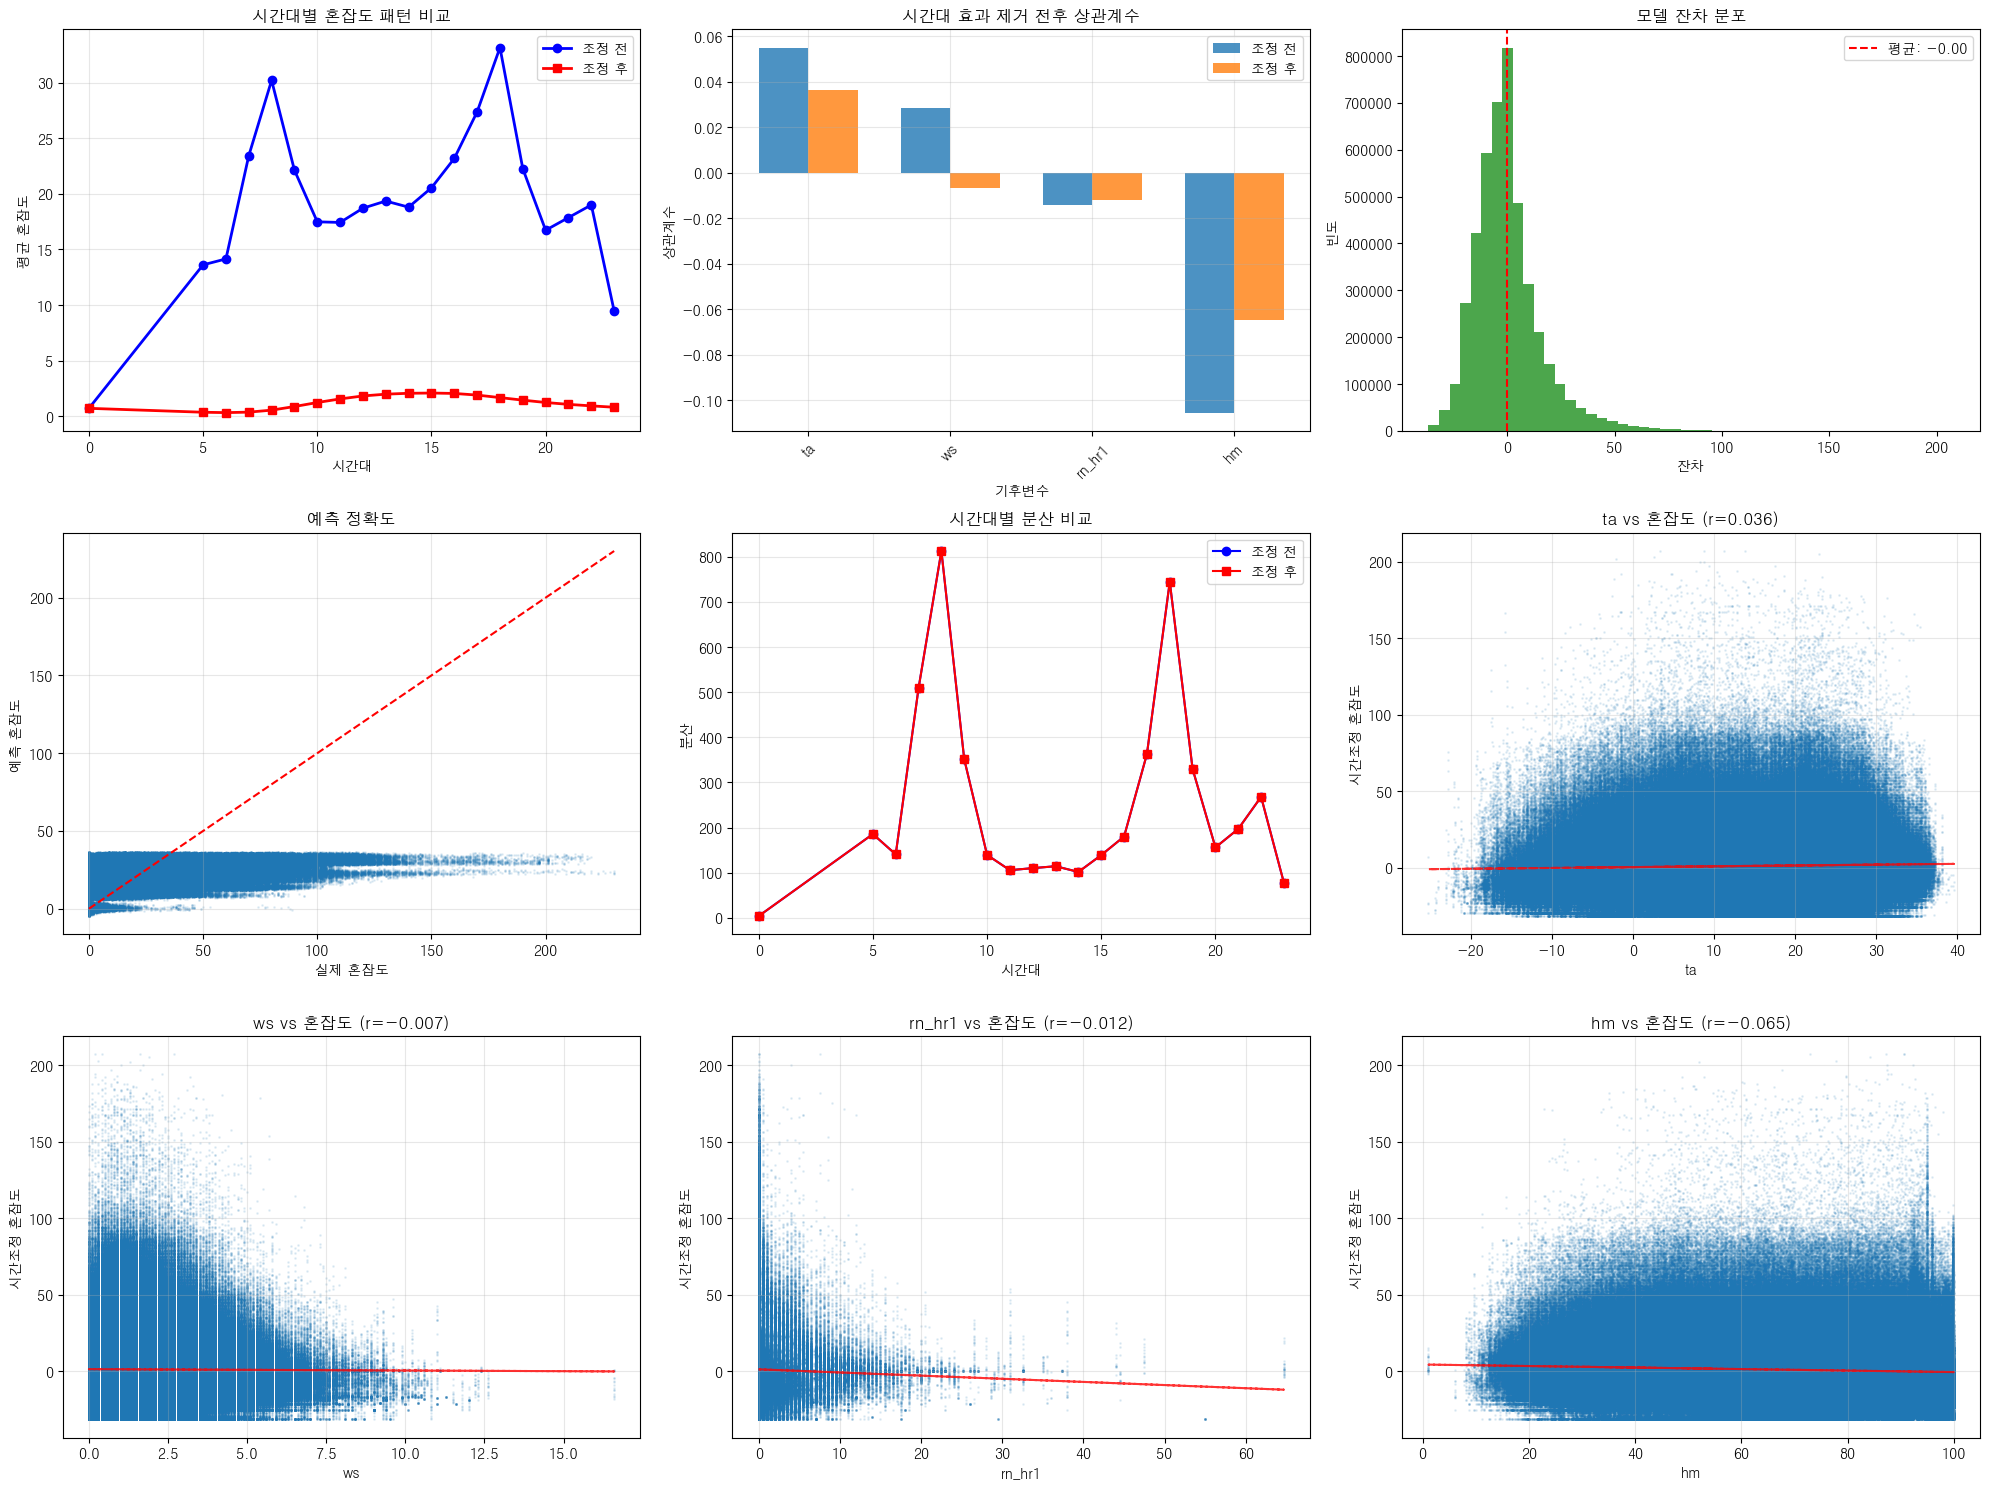

In [50]:
# 시간대 효과 제거 전후 비교 시각화
plt.figure(figsize=(20, 15))

# 1) 시간대별 혼잡도 패턴 (조정 전후)
plt.subplot(3, 3, 1)
hourly_original = df_model.groupby('m_hr1')['congestion'].mean()
hourly_adjusted = df_model.groupby('m_hr1')['congestion_time_adjusted'].mean()

plt.plot(hourly_original.index, hourly_original.values, 'b-o', label='조정 전', linewidth=2)
plt.plot(hourly_adjusted.index, hourly_adjusted.values, 'r-s', label='조정 후', linewidth=2)
plt.xlabel('시간대')
plt.ylabel('평균 혼잡도')
plt.title('시간대별 혼잡도 패턴 비교')
plt.legend()
plt.grid(True, alpha=0.3)

# 2) 상관계수 변화 비교
plt.subplot(3, 3, 2)
vars_for_plot = available_weather_vars[:6]  # 최대 6개만
before_corrs = [correlation_results[var]['before'] for var in vars_for_plot]
after_corrs = [correlation_results[var]['after'] for var in vars_for_plot]

x = np.arange(len(vars_for_plot))
width = 0.35

plt.bar(x - width/2, before_corrs, width, label='조정 전', alpha=0.8)
plt.bar(x + width/2, after_corrs, width, label='조정 후', alpha=0.8)
plt.xlabel('기후변수')
plt.ylabel('상관계수')
plt.title('시간대 효과 제거 전후 상관계수')
plt.xticks(x, vars_for_plot, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# 3) 잔차 분포
plt.subplot(3, 3, 3)
residuals = df_model['congestion'] - df_model['climate_prediction'] - df_model['time_effect']
plt.hist(residuals, bins=50, alpha=0.7, color='green')
plt.xlabel('잔차')
plt.ylabel('빈도')
plt.title('모델 잔차 분포')
plt.axvline(residuals.mean(), color='red', linestyle='--', label=f'평균: {residuals.mean():.2f}')
plt.legend()

# 4) 예측값 vs 실제값
plt.subplot(3, 3, 4)
predictions = df_model['climate_prediction'] + df_model['time_effect']
plt.scatter(df_model['congestion'], predictions, alpha=0.1, s=1)
plt.plot([df_model['congestion'].min(), df_model['congestion'].max()], 
         [df_model['congestion'].min(), df_model['congestion'].max()], 'r--')
plt.xlabel('실제 혼잡도')
plt.ylabel('예측 혼잡도')
plt.title('예측 정확도')
plt.grid(True, alpha=0.3)

# 5) 시간대별 분산 비교
plt.subplot(3, 3, 5)
hourly_var_orig = df_model.groupby('m_hr1')['congestion'].var()
hourly_var_adj = df_model.groupby('m_hr1')['congestion_time_adjusted'].var()

plt.plot(hourly_var_orig.index, hourly_var_orig.values, 'b-o', label='조정 전')
plt.plot(hourly_var_adj.index, hourly_var_adj.values, 'r-s', label='조정 후')
plt.xlabel('시간대')
plt.ylabel('분산')
plt.title('시간대별 분산 비교')
plt.legend()
plt.grid(True, alpha=0.3)

# 6) 주요 기후변수별 산점도 (조정 후)
for i, var in enumerate(available_weather_vars[:4]):
    plt.subplot(3, 3, 6+i)
    plt.scatter(df_model[var], df_model['congestion_time_adjusted'], alpha=0.1, s=1)
    
    # 추세선 추가
    z = np.polyfit(df_model[var], df_model['congestion_time_adjusted'], 1)
    p = np.poly1d(z)
    plt.plot(df_model[var], p(df_model[var]), "r--", alpha=0.8)
    
    corr = correlation_results[var]['after']
    plt.xlabel(var)
    plt.ylabel('시간조정 혼잡도')
    plt.title(f'{var} vs 혼잡도 (r={corr:.3f})')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [53]:
# 최종 결론 정리
print("🎯 고정효과 회귀모델 분석 최종 결론")
print("="*60)

print(f"\n📊 모델 성능 요약:")
print(f"  전체 모델 R²: {r2_full:.4f}")
print(f"  시간대 효과 기여도: {time_explanation:.1f}%")
print(f"  기후변수 기여도: {climate_explanation:.1f}%")

print(f"\n🌡️ 기후변수 순수 효과 발견:")

# 유의한 효과가 있는 변수들
significant_vars = [(var, results['after'], results['p_value']) 
                   for var, results in correlation_results.items() 
                   if results['p_value'] < 0.05]

if significant_vars:
    print(f"  ✅ 통계적으로 유의한 기후 효과: {len(significant_vars)}개")
    
    # 효과 크기별 정렬
    significant_vars.sort(key=lambda x: abs(x[1]), reverse=True)
    
    for var, corr, p_val in significant_vars:
        direction = "양의" if corr > 0 else "음의"
        if abs(corr) >= 0.3:
            strength = "강한"
        elif abs(corr) >= 0.1:
            strength = "중간"
        else:
            strength = "상관없다 봐도 무관한"
        
        print(f"    {var}: {direction} {strength} 상관 (r={corr:+.4f}, p={p_val:.4f})")
        
        # 실용적 해석
        if 'ta' in var and abs(corr) > 0.05:
            temp_effect = corr * 10  # 10도 변화시 효과
            print(f"      → 기온 10°C 변화시 혼잡도 {temp_effect:+.2f} 변화")
        
        elif 'hm' in var and abs(corr) > 0.05:
            humid_effect = corr * 20  # 습도 20% 변화시 효과
            print(f"      → 습도 20% 변화시 혼잡도 {humid_effect:+.2f} 변화")

else:
    print("  ❌ 통계적으로 유의한 기후 효과를 발견하지 못함")

print(f"\n📈 분석의 신뢰성:")
print(f"  데이터 크기: {len(df_model):,}개 관측치")
print(f"  시간대 범위: {df_model['m_hr1'].nunique()}개 시간대")
print(f"  시간대 효과 제거 성공: 분산 {(1 - time_adjusted_congestion.var()/y.var())*100:.1f}% 감소")

# 잔차 정규성 확인
from scipy.stats import shapiro
_, shapiro_p = shapiro(residuals[:5000] if len(residuals) > 5000 else residuals)
print(f"  잔차 정규성: p={shapiro_p:.4f} {'✅' if shapiro_p > 0.05 else '⚠️'}")

🎯 고정효과 회귀모델 분석 최종 결론

📊 모델 성능 요약:
  전체 모델 R²: 0.1621
  시간대 효과 기여도: 97.1%
  기후변수 기여도: 2.9%

🌡️ 기후변수 순수 효과 발견:
  ✅ 통계적으로 유의한 기후 효과: 4개
    hm: 음의 상관없다 봐도 무관한 상관 (r=-0.0648, p=0.0000)
      → 습도 20% 변화시 혼잡도 -1.30 변화
    ta: 양의 상관없다 봐도 무관한 상관 (r=+0.0363, p=0.0000)
    rn_hr1: 음의 상관없다 봐도 무관한 상관 (r=-0.0122, p=0.0000)
    ws: 음의 상관없다 봐도 무관한 상관 (r=-0.0069, p=0.0000)

📈 분석의 신뢰성:
  데이터 크기: 4,468,051개 관측치
  시간대 범위: 20개 시간대
  시간대 효과 제거 성공: 분산 15.6% 감소
  잔차 정규성: p=0.0000 ⚠️
